In [9]:
import transformers
import ultralytics
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from emotion_detection_utils import *
import torch
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [10]:
from transformers import AutoTokenizer, AutoModel
from huggingface_hub import hf_hub_download
from ultralytics import YOLO
from supervision import Detections
from PIL import Image

# download model
model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")

# load model
model = YOLO(model_path)

# define device
device = torch.device('cuda' if torch.cuda.is_available() == True else 'cpu')

In [11]:
# Emotion detection

import torch
import torch.nn as nn
import torchvision.transforms as transform
import torch.optim as optim

data_dir = 'emotion_dataset/train'
all_images = []
all_labels = []

# load folders and append images and labels using pre-defined function 
for emotion in os.listdir(data_dir):
    emotion_folder = os.path.join(data_dir, emotion)
    images, labels = load_images_and_labels(emotion_folder, emotion)
    all_images.append(images)
    all_labels.append(labels)

In [12]:
# concatenate all images and labels at once

X_train_images = np.concatenate(all_images, axis=0).astype(np.float32) / 255
X_train_labels = np.concatenate(all_labels, axis=0)

In [13]:
# Set up dict and inverse dict for swapping between emotions and labels 

emotiontolabel = {
    'happy': 0,
    'sad': 1,
    'angry': 2,
    'surprised': 3,
    'neutral': 4,
    'fearful': 5,
    'disgusted': 6
}

labeltoemotion = {label:emotion for emotion, label in emotiontolabel.items()}

# Convert text labels to their corresponding number
X_train_labels = np.array([emotiontolabel[label] for label in X_train_labels])

In [14]:
data_dir = 'emotion_dataset/test'
all_images = []
all_labels = []

# load folders and append images and labels using pre-defined function 
for emotion in os.listdir(data_dir):
    emotion_folder = os.path.join(data_dir, emotion)
    images, labels = load_images_and_labels(emotion_folder, emotion)
    all_images.append(images)
    all_labels.append(labels)

X_test_images = np.concatenate(all_images, axis=0).astype(np.float32) / 255
X_test_labels = np.concatenate(all_labels, axis=0)

In [15]:
X_test_labels = np.array([emotiontolabel[label] for label in X_test_labels])

In [16]:
from torch.utils.data import DataLoader

X_train_image = torch.tensor(X_train_images, dtype=torch.float32).permute(0,3,1,2).to(device)  # Ensure it's float
X_train_label = torch.tensor(X_train_labels, dtype=torch.long).to(device)  # Ensure it's long for labels

X_test_image = torch.tensor(X_test_images, dtype=torch.float32).permute(0,3,1,2).to(device)  # Ensure it's float
X_test_label = torch.tensor(X_test_labels, dtype=torch.long).to(device)  # Ensure it's long for labels

# Create the dataset
train_dataset = CustomDataset(X_train_image, X_train_label)
val_dataset = CustomDataset(X_test_image, X_test_label)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [17]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding = 1)  # 3 channels for RGB
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding = 2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.bn4 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.25) # Dropout layer with 10% probability
        
        # Calculate output size after convolutions and pooling
        self.fc1 = nn.Linear(4608, 256)  # Adjusted for output from conv layers
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 7)
        

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(nn.ReLU()(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.pool(nn.ReLU()(self.bn4(self.conv4(x))))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
emotion_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(emotion_model.parameters(), lr=0.0001)

emotion_model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=7, bias=True)
)

In [19]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() == True else 'cpu')
print(device)


cuda


Epoch [1/50], Loss: 1.5964
Validation Loss: 1.4334, Accuracy: 44.64%
Epoch [2/50], Loss: 1.3753
Validation Loss: 1.3138, Accuracy: 48.43%
Epoch [3/50], Loss: 1.2675
Validation Loss: 1.1983, Accuracy: 53.34%
Epoch [4/50], Loss: 1.2037
Validation Loss: 1.1637, Accuracy: 54.99%
Epoch [5/50], Loss: 1.1586
Validation Loss: 1.1667, Accuracy: 55.15%


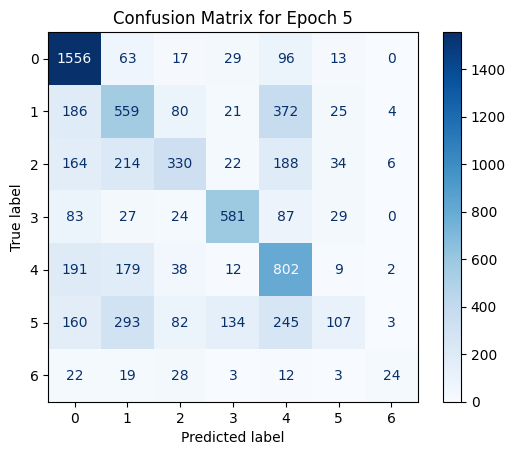

Epoch [6/50], Loss: 1.1104
Validation Loss: 1.1118, Accuracy: 57.63%
Epoch [7/50], Loss: 1.0780
Validation Loss: 1.1403, Accuracy: 56.77%
Epoch [8/50], Loss: 1.0428
Validation Loss: 1.0859, Accuracy: 58.82%
Epoch [9/50], Loss: 1.0105
Validation Loss: 1.0736, Accuracy: 59.58%
Epoch [10/50], Loss: 0.9806
Validation Loss: 1.0714, Accuracy: 59.65%


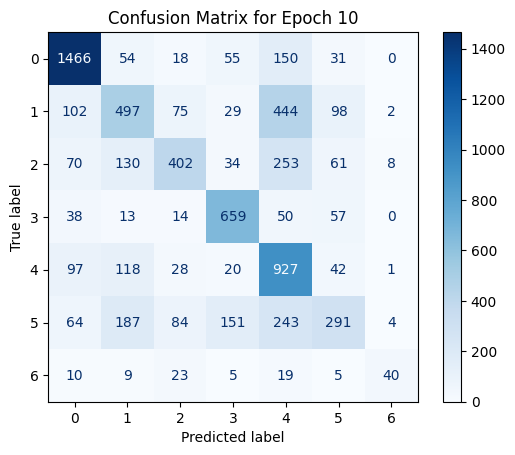

Epoch [11/50], Loss: 0.9554
Validation Loss: 1.0727, Accuracy: 60.10%
Epoch [12/50], Loss: 0.9245
Validation Loss: 1.1371, Accuracy: 58.14%
Epoch [13/50], Loss: 0.8981
Validation Loss: 1.0318, Accuracy: 62.09%
Epoch [14/50], Loss: 0.8693
Validation Loss: 1.0271, Accuracy: 62.71%
Epoch [15/50], Loss: 0.8391
Validation Loss: 1.0540, Accuracy: 61.60%


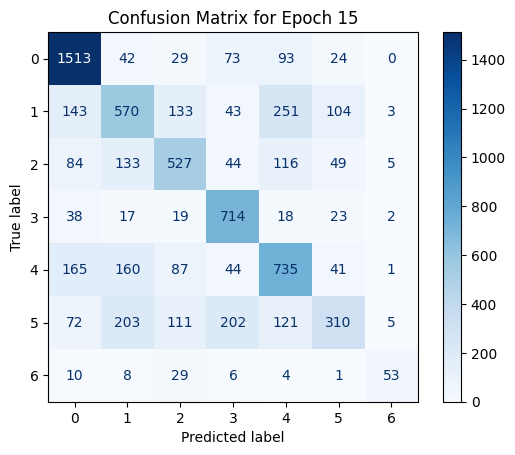

Epoch [16/50], Loss: 0.8228
Validation Loss: 1.0812, Accuracy: 61.79%
Epoch [17/50], Loss: 0.7908
Validation Loss: 1.0504, Accuracy: 62.98%
Epoch [18/50], Loss: 0.7670
Validation Loss: 1.0731, Accuracy: 62.36%
Epoch [19/50], Loss: 0.7452
Validation Loss: 1.0238, Accuracy: 63.07%
Epoch [20/50], Loss: 0.7208
Validation Loss: 1.0708, Accuracy: 62.32%


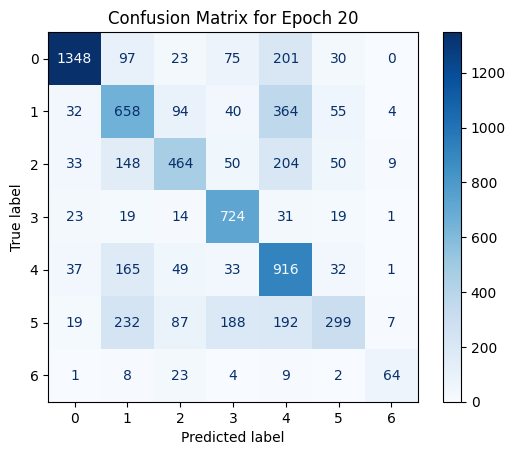

Epoch [21/50], Loss: 0.7034
Validation Loss: 1.0457, Accuracy: 63.61%
Epoch [22/50], Loss: 0.6755
Validation Loss: 1.0510, Accuracy: 63.56%
Epoch [23/50], Loss: 0.6563
Validation Loss: 1.1124, Accuracy: 62.76%
Epoch [24/50], Loss: 0.6315
Validation Loss: 1.0593, Accuracy: 63.62%
Epoch [25/50], Loss: 0.6101
Validation Loss: 1.0510, Accuracy: 64.15%


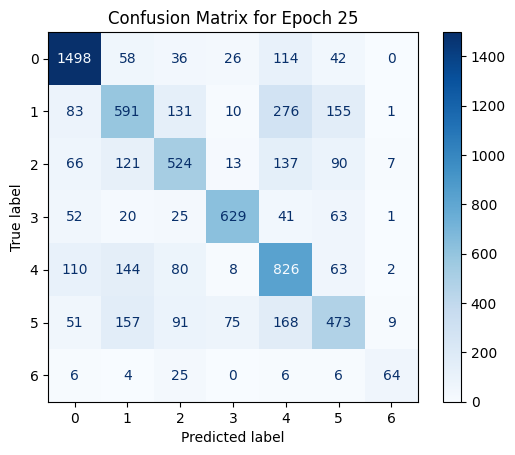

Epoch [26/50], Loss: 0.5980
Validation Loss: 1.0768, Accuracy: 63.85%
Epoch [27/50], Loss: 0.5770
Validation Loss: 1.1122, Accuracy: 62.75%
Epoch [28/50], Loss: 0.5541
Validation Loss: 1.0821, Accuracy: 64.70%
Epoch [29/50], Loss: 0.5335
Validation Loss: 1.0991, Accuracy: 63.54%
Epoch [30/50], Loss: 0.5246
Validation Loss: 1.1189, Accuracy: 64.29%


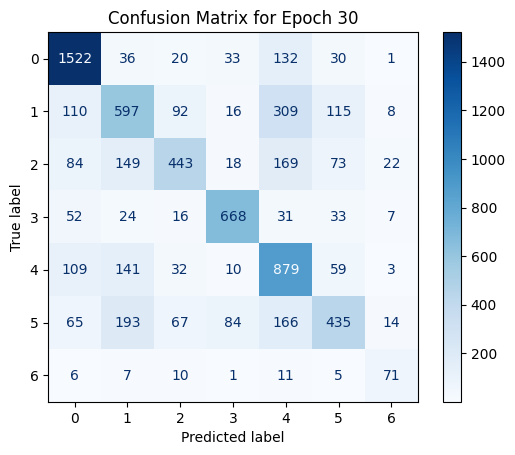

Epoch [31/50], Loss: 0.5120
Validation Loss: 1.1347, Accuracy: 63.56%
Epoch [32/50], Loss: 0.4911
Validation Loss: 1.1604, Accuracy: 64.28%
Epoch [33/50], Loss: 0.4739
Validation Loss: 1.1396, Accuracy: 64.14%
Epoch [34/50], Loss: 0.4528
Validation Loss: 1.1878, Accuracy: 64.74%
Epoch [35/50], Loss: 0.4425
Validation Loss: 1.1542, Accuracy: 64.67%


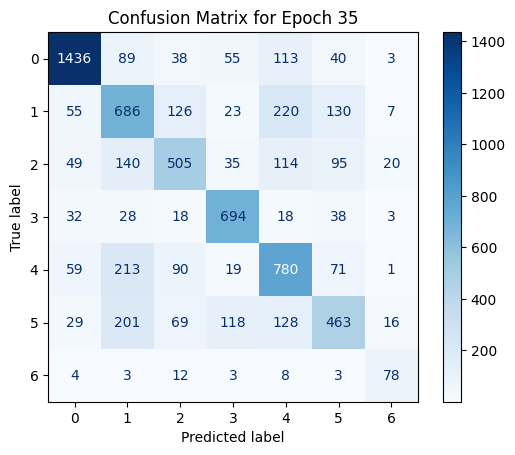

Epoch [36/50], Loss: 0.4374
Validation Loss: 1.2380, Accuracy: 63.90%
Epoch [37/50], Loss: 0.4195
Validation Loss: 1.1996, Accuracy: 64.80%
Epoch [38/50], Loss: 0.4052
Validation Loss: 1.2472, Accuracy: 63.79%
Epoch [39/50], Loss: 0.3869
Validation Loss: 1.2598, Accuracy: 62.83%
Epoch [40/50], Loss: 0.3848
Validation Loss: 1.1783, Accuracy: 65.27%


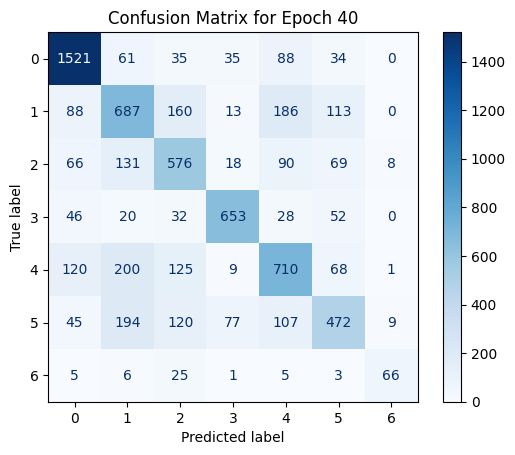

Epoch [41/50], Loss: 0.3709
Validation Loss: 1.3168, Accuracy: 63.99%
Epoch [42/50], Loss: 0.3546
Validation Loss: 1.2761, Accuracy: 64.68%
Epoch [43/50], Loss: 0.3458
Validation Loss: 1.2825, Accuracy: 64.29%
Epoch [44/50], Loss: 0.3398
Validation Loss: 1.3214, Accuracy: 64.35%
Epoch [45/50], Loss: 0.3286
Validation Loss: 1.2373, Accuracy: 65.13%


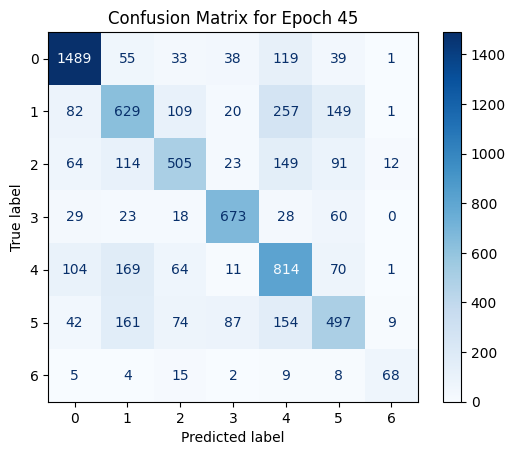

Epoch [46/50], Loss: 0.3173
Validation Loss: 1.2893, Accuracy: 64.29%
Epoch [47/50], Loss: 0.3110
Validation Loss: 1.2738, Accuracy: 64.80%
Epoch [48/50], Loss: 0.2978
Validation Loss: 1.3349, Accuracy: 65.07%
Epoch [49/50], Loss: 0.2886
Validation Loss: 1.3060, Accuracy: 65.42%
Epoch [50/50], Loss: 0.2872
Validation Loss: 1.4160, Accuracy: 63.51%


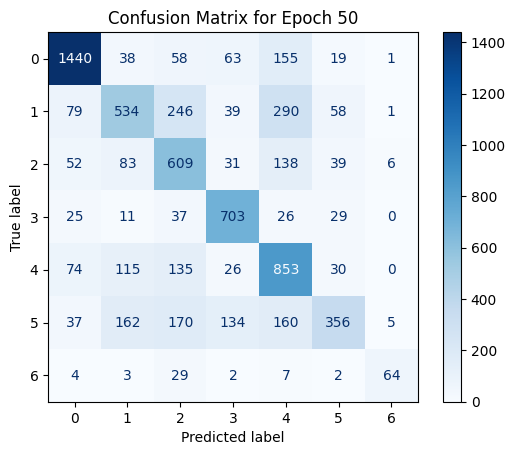

In [25]:
num_epochs = 50

for epoch in range(num_epochs):
    emotion_model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for images, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = emotion_model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    emotion_model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_outputs = emotion_model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item()

            _, predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
            
            all_labels.extend(val_labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

    # Calculate and display confusion matrix
    if epoch%5 == 4:
        cm = confusion_matrix(all_labels, all_predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for Epoch {epoch+1}')
        plt.show()
    
   

In [26]:

unique_labels, counts = np.unique(X_test_labels, return_counts = True)
unique_emotions = [labeltoemotion[label] for label in unique_labels]

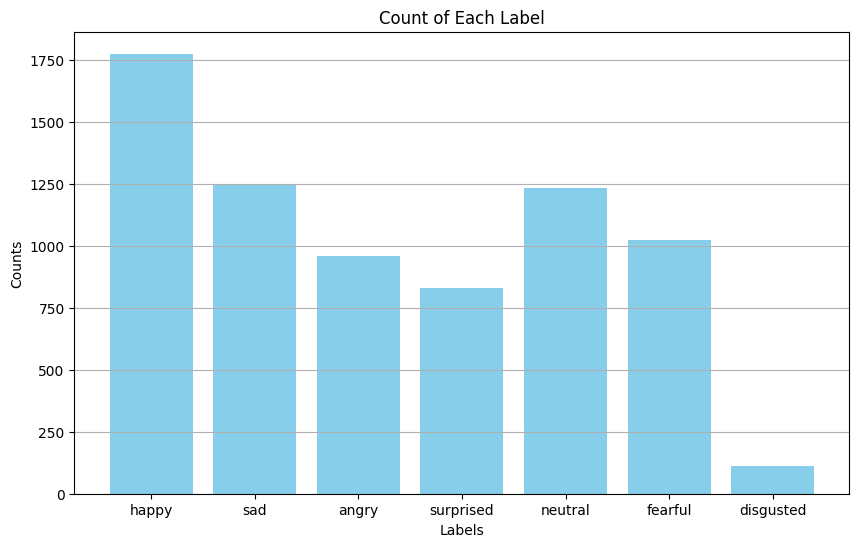

In [27]:
# Plot the amount of labels for each emotion

plt.figure(figsize=(10, 6))
plt.bar(unique_emotions, counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Count of Each Label')
plt.xticks(unique_labels)
plt.grid(axis='y')
plt.show()